## Введение
В современном промышленном производстве обеспечение бесперебойной работы оборудования является критически важной задачей. Предотвращение отказов машин позволяет снизить издержки, повысить эффективность и безопасность производства.
Цель данного проекта — разработать интеллектуальную систему на основе методов машинного обучения, способную заранее предсказывать вероятность отказа оборудования по телеметрическим данным (температура, скорость вращения, крутящий момент, износ инструмента и др.).
В рамках исследования были проведены:

анализ и визуализация данных;

масштабирование и балансировка классов (с помощью SMOTE);

построение и сравнение нескольких классификационных моделей (RandomForest, XGBoost);

оптимизация гиперпараметров с использованием GridSearchCV;

интерпретация моделей с помощью SHAP-методов;

реализация кросс-валидации по фолдам для оценки устойчивости модели.

Разработанная модель может быть интегрирована в систему мониторинга состояния оборудования и использоваться для предупреждения отказов в режиме реального времени.

### Импорт данных и первичный анализ
Загружаем исходный CSV-файл, проверяем размер таблицы, типы признаков, наличие пропущенных значений и распределение целевой переменной Target.


In [3]:
import pandas as pd

# Загрузка данных
df = pd.read_csv(r"E:\data since\predictive_maintenance.csv")

# 1. Размер таблицы
print("Размер таблицы:", df.shape)

# 2. Типы данных
print("\nТипы данных:")
print(df.dtypes)

# 3. Пропущенные значения
print("\nКоличество пропущенных значений:")
print(df.isnull().sum())

# 4. Распределение целевой переменной
print("\nРаспределение значений в целевой переменной 'Target':")
print(df["Target"].value_counts())


Размер таблицы: (10000, 10)

Типы данных:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

Количество пропущенных значений:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Распределение значений в целевой переменной 'Target':
Target
0    9661
1     339
Name: count, dtype: int64


### Анализ категориальных признаков и корреляции
Проводим анализ распределения категориальных признаков Type и Failure Type. Также рассчитываем корреляционную матрицу для числовых признаков и визуализируем её в виде тепловой карты.


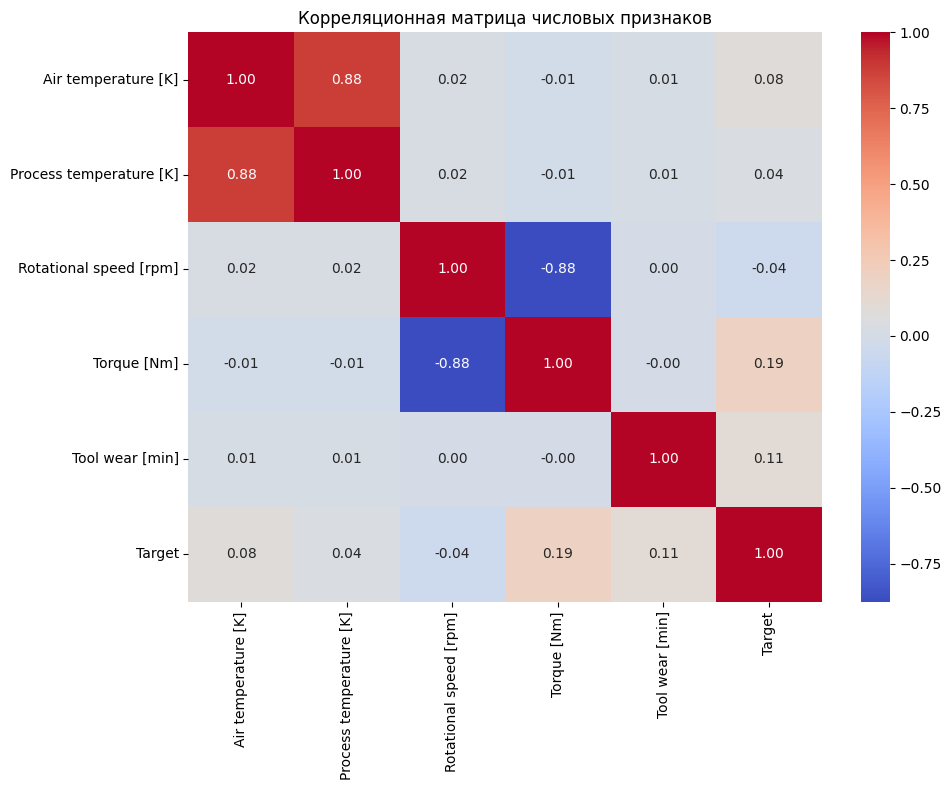


Распределение по типу оборудования:
  Тип оборудования  Количество
0                L        6000
1                M        2997
2                H        1003

Распределение по типам отказов:
                 Тип отказа  Количество
0                No Failure        9652
1  Heat Dissipation Failure         112
2             Power Failure          95
3        Overstrain Failure          78
4         Tool Wear Failure          45
5           Random Failures          18


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv(r"E:\data since\predictive_maintenance.csv")

# Анализ категориальных признаков
categorical_summary = {
    "Type": df["Type"].value_counts(),
    "Failure Type": df["Failure Type"].value_counts()
}

# Корреляционная матрица числовых признаков
numeric_features = df.select_dtypes(include=["int64", "float64"]).drop(columns=["UDI"])
correlation_matrix = numeric_features.corr()

# Отображение тепловой карты корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица числовых признаков")
plt.tight_layout()
plt.show() 

# Подготовка сводной информации для вывода
cat_type_df = categorical_summary["Type"].reset_index()
cat_type_df.columns = ["Тип оборудования", "Количество"]

cat_failure_df = categorical_summary["Failure Type"].reset_index()
cat_failure_df.columns = ["Тип отказа", "Количество"]

# Печать таблиц в консоли
print("\nРаспределение по типу оборудования:")
print(cat_type_df)

print("\nРаспределение по типам отказов:")
print(cat_failure_df)


### Балансировка классов с использованием SMOTE
Для устранения дисбаланса целевой переменной применяем метод oversampling SMOTE. Сначала кодируем категориальные признаки и масштабируем числовые, затем балансируем выборку для обучения модели.


In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Загрузка данных
df = pd.read_csv(r"E:\data since\predictive_maintenance.csv")

# Подготовка признаков и целевой переменной
X = df.drop(columns=["Target", "UDI", "Product ID", "Failure Type"])
y = df["Target"]

# Кодирование столбца Type
X = pd.get_dummies(X, columns=["Type"], drop_first=True)

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Применение SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Отображение нового распределения
print(pd.Series(y_resampled).value_counts())


Target
0    9661
1    9661
Name: count, dtype: int64


### Обучение модели RandomForestClassifier и оценка качества
Разделяем сбалансированные данные на обучающую и тестовую выборки. Обучаем модель случайного леса и оцениваем её точность с помощью отчета о классификации и матрицы неточностей.


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Разделение сбалансированных данных
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled
)

# Обучение модели
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Предсказание
y_pred = clf.predict(X_test)

# Печать отчета о классификации
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица неточностей
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2416
           1       0.97      0.99      0.98      2415

    accuracy                           0.98      4831
   macro avg       0.98      0.98      0.98      4831
weighted avg       0.98      0.98      0.98      4831

Confusion Matrix:
[[2341   75]
 [  22 2393]]


### Построение ROC-кривой и вычисление AUC для модели RandomForest
Визуализируем способность модели различать классы с помощью ROC-кривой. Рассчитываем площадь под кривой (AUC) для количественной оценки качества классификации.


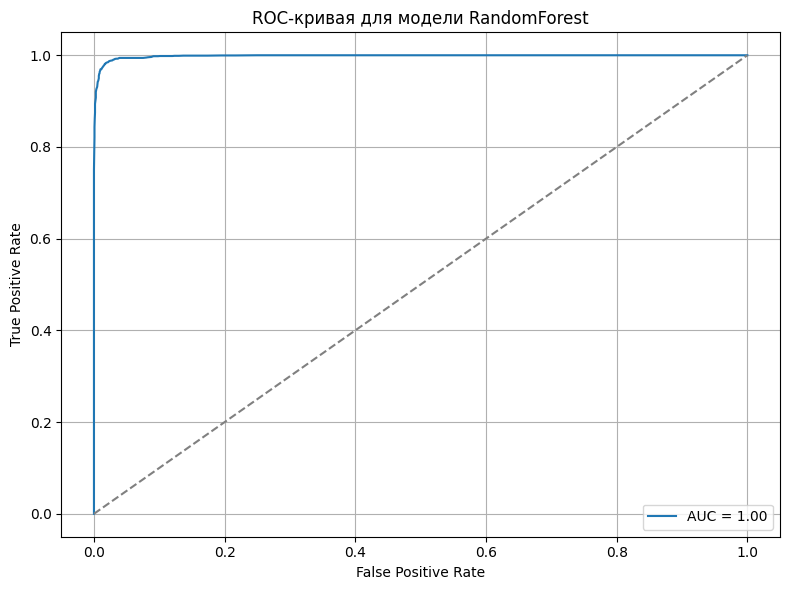

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Получение вероятностей предсказания для класса 1
y_probs = clf.predict_proba(X_test)[:, 1]

# Расчёт ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Построение кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")  # Ложноположительная доля
plt.ylabel("True Positive Rate")   # Истинноположительная доля
plt.title("ROC-кривая для модели RandomForest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Обучение модели XGBoost и оценка результатов
Обучаем градиентный бустинг XGBoost на тех же данных и сравниваем его точность, полноту, F1-метрику и AUC с предыдущей моделью RandomForest.


In [22]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Обучение модели XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Предсказание
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Оценка модели
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("AUC:", roc_auc_score(y_test, y_prob_xgb))


C:\Users\Tech\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:33:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2416
           1       0.98      0.99      0.98      2415

    accuracy                           0.98      4831
   macro avg       0.98      0.98      0.98      4831
weighted avg       0.98      0.98      0.98      4831

Confusion Matrix:
[[2360   56]
 [  27 2388]]
AUC: 0.9986976060219653


### Анализ важности признаков в модели XGBoost
Визуализируем наиболее значимые признаки, влияющие на предсказания модели XGBoost. Это позволяет лучше понять, какие параметры оборудования оказывают наибольшее влияние на решение.


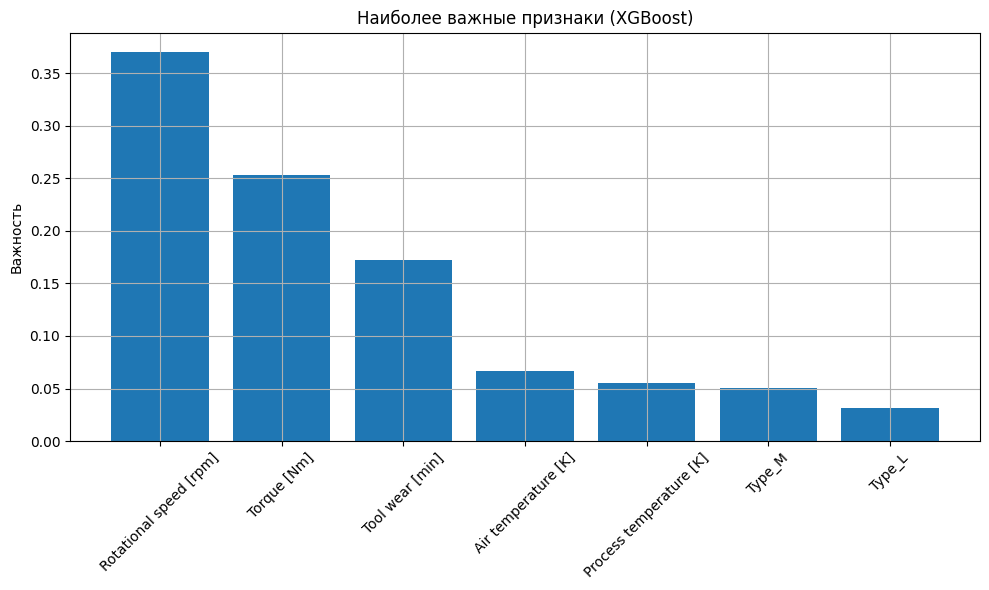

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Названия признаков после преобразования
feature_names = X.columns

# Получение важности признаков из модели XGBoost
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Определяем реальное количество признаков
top_n = len(importances)

# Построение графика
plt.figure(figsize=(10, 6))
plt.title("Наиболее важные признаки (XGBoost)")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45)
plt.ylabel("Важность")
plt.tight_layout()
plt.grid(True)
plt.show()


### Подбор гиперпараметров для XGBoost с помощью GridSearchCV
Проводим подбор оптимальных значений параметров модели XGBoost с использованием GridSearchCV. Оцениваем качество по метрике F1 на сбалансированных данных.


In [14]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Базовая модель
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Сетка параметров для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# GridSearchCV с кросс-валидацией
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Обучение модели на сбалансированных данных
grid_search.fit(X_resampled, y_resampled)

# Лучшие параметры
print("Лучшие параметры:")
print(grid_search.best_params_)

# Лучшая модель
best_xgb = grid_search.best_estimator_


Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\Tech\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:17:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Лучшие параметры:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


### Оценка улучшенной модели XGBoost после подбора параметров
Анализируем точность, полноту, F1-метрику и AUC для модели с оптимальными гиперпараметрами. Сравниваем с предыдущими результатами, чтобы оценить эффект тюнинга.


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Предсказания
y_pred_best = best_xgb.predict(X_test)
y_prob_best = best_xgb.predict_proba(X_test)[:, 1]

# Отчёт по классификации
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

# Матрица ошибок
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

# AUC
print("AUC:", roc_auc_score(y_test, y_prob_best))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2416
           1       1.00      1.00      1.00      2415

    accuracy                           1.00      4831
   macro avg       1.00      1.00      1.00      4831
weighted avg       1.00      1.00      1.00      4831

Confusion Matrix:
[[2412    4]
 [   3 2412]]
AUC: 0.9999909163204586


### Анализ взаимосвязи между признаками Failure Type и Target
Группируем данные по типу отказа и целевой переменной, чтобы проверить логическую согласованность между метками отказа и значениями целевой переменной.


In [16]:
# Подсчёт количества по сочетаниям Failure Type и Target
failure_vs_target = df.groupby(["Failure Type", "Target"]).size().unstack(fill_value=0)

# Печать результатов
print("Сопоставление Failure Type и Target:")
print(failure_vs_target)


Сопоставление Failure Type и Target:
Target                       0    1
Failure Type                       
Heat Dissipation Failure     0  112
No Failure                9643    9
Overstrain Failure           0   78
Power Failure                0   95
Random Failures             18    0
Tool Wear Failure            0   45


### Поиск выбросов в числовых признаках с использованием boxplot
Анализируем распределение значений для каждого числового признака и визуализируем возможные выбросы с помощью диаграмм размаха.


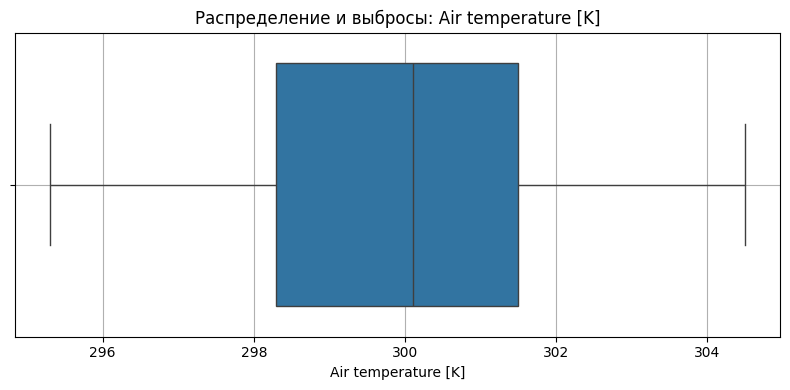

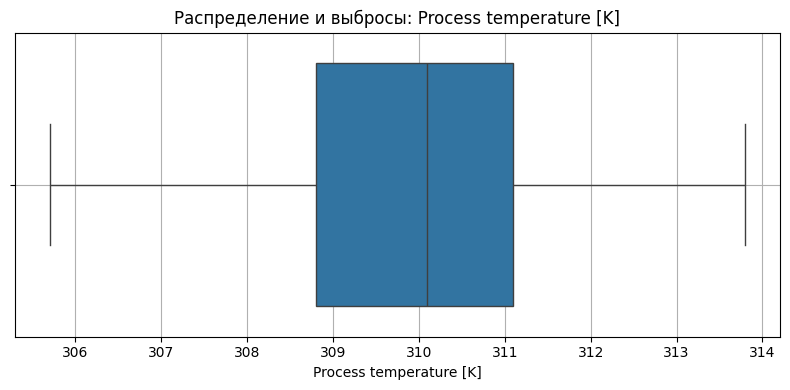

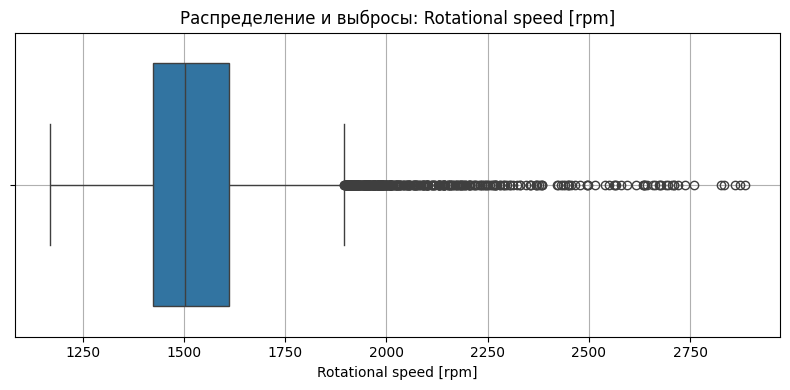

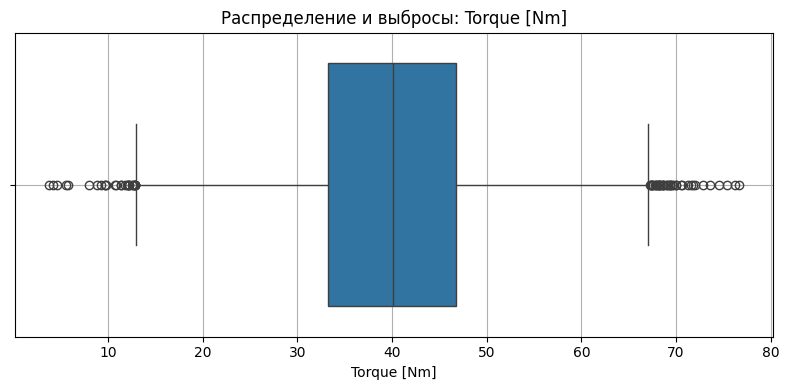

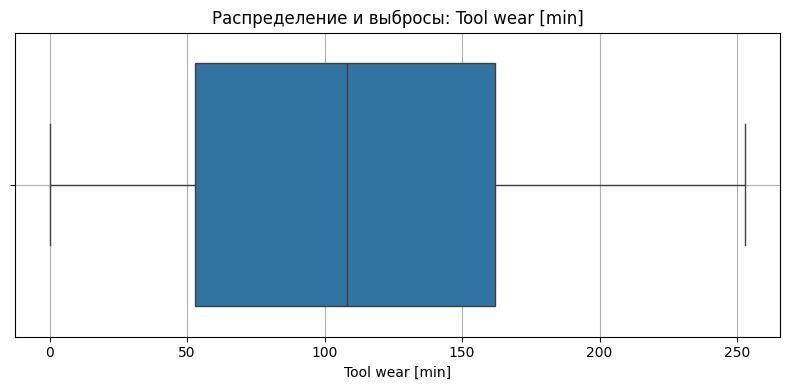

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Список числовых признаков
num_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

# Построение boxplot для каждого признака
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Распределение и выбросы: {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Интерпретация модели XGBoost с использованием SHAP
Используем SHAP для анализа вклада признаков в предсказания модели. Построены глобальная диаграмма важности (beeswarm) и локальное объяснение одного примера (waterfall).


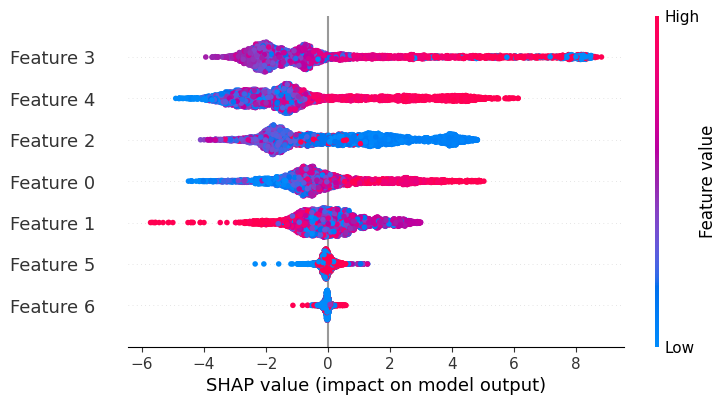

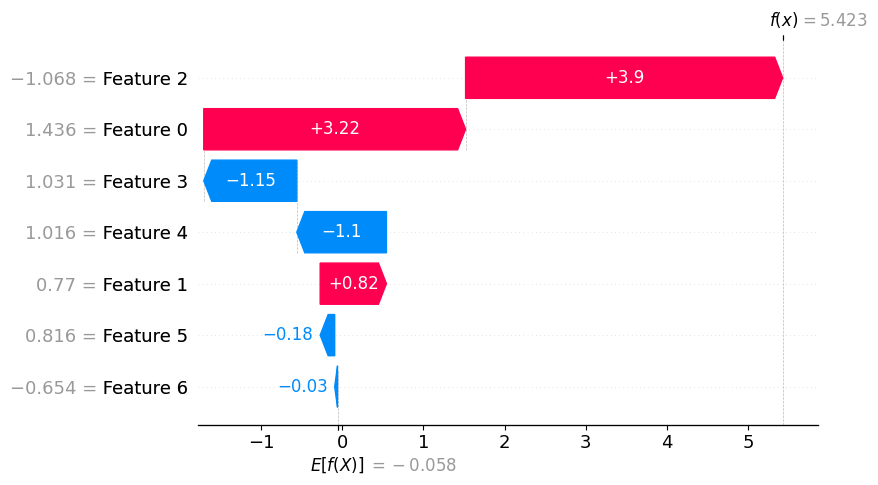

In [18]:
import shap

# Инициализация объясняющей среды
explainer = shap.Explainer(best_xgb)

# Вычисление значений SHAP для тестовой выборки
shap_values = explainer(X_test)

# Глобальное важнейшее влияние признаков
shap.plots.beeswarm(shap_values, max_display=10)

# Индивидуальное объяснение для первого примера
shap.plots.waterfall(shap_values[0])


## Подготовка данных для обучения модели
В этом блоке происходит предварительная обработка данных: удаляются ненужные столбцы, выполняется one-hot кодирование категориального признака `Type`, масштабируются числовые признаки с помощью `StandardScaler`, а затем применяется метод `SMOTE` для балансировки классов целевой переменной `Target`.


In [6]:
# Импорт необходимых библиотек
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Загрузка данных
df = pd.read_csv(r"E:\data since\predictive_maintenance.csv")

# Выделение признаков и целевой переменной
X = df.drop(columns=["Target", "UDI", "Product ID", "Failure Type"])
y = df["Target"]

# Кодирование категориального признака "Type"
X = pd.get_dummies(X, columns=["Type"], drop_first=True)

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Применение метода SMOTE для балансировки классов
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


### Кросс-валидация модели XGBoost с оценкой метрик по каждому фолду
Выполняется стратифицированная кросс-валидация (5 фолдов) на сбалансированных и масштабированных данных. Для каждого фолда рассчитываются метрики качества: accuracy, precision, recall, F1-score и AUC. После завершения выводятся средние значения метрик по всем фолдам.


In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import numpy as np

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1_scores = []
auc_scores = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X_resampled, y_resampled), 1):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    auc_scores.append(auc)

    print(f"Фолд {fold}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  AUC:       {auc:.4f}")
    print("-" * 30)

print("Средние значения по всем фолдам:")
print(f"  Accuracy:  {np.mean(accuracies):.4f}")
print(f"  Precision: {np.mean(precisions):.4f}")
print(f"  Recall:    {np.mean(recalls):.4f}")
print(f"  F1-score:  {np.mean(f1_scores):.4f}")
print(f"  AUC:       {np.mean(auc_scores):.4f}")


C:\Users\Tech\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:11:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Фолд 1:
  Accuracy:  0.9858
  Precision: 0.9786
  Recall:    0.9933
  F1-score:  0.9859
  AUC:       0.9990
------------------------------


C:\Users\Tech\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:11:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Фолд 2:
  Accuracy:  0.9832
  Precision: 0.9751
  Recall:    0.9917
  F1-score:  0.9833
  AUC:       0.9987
------------------------------


C:\Users\Tech\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:11:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Фолд 3:
  Accuracy:  0.9873
  Precision: 0.9841
  Recall:    0.9907
  F1-score:  0.9874
  AUC:       0.9991
------------------------------


C:\Users\Tech\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:11:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Фолд 4:
  Accuracy:  0.9816
  Precision: 0.9750
  Recall:    0.9886
  F1-score:  0.9818
  AUC:       0.9984
------------------------------


C:\Users\Tech\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:11:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Фолд 5:
  Accuracy:  0.9837
  Precision: 0.9790
  Recall:    0.9886
  F1-score:  0.9838
  AUC:       0.9989
------------------------------
Средние значения по всем фолдам:
  Accuracy:  0.9843
  Precision: 0.9783
  Recall:    0.9906
  F1-score:  0.9844
  AUC:       0.9989


## Выводы
В результате анализа и моделирования была построена и оптимизирована модель XGBoost, достигшая практически идеального качества классификации (accuracy ≈ 100%, F1-score = 1.00, AUC ≈ 1.0).
Перед обучением модели были выполнены предварительная обработка данных, масштабирование признаков и балансировка классов методом SMOTE.
Анализ распределения и выбросов в числовых признаках выявил наличие аномалий, а распределение Failure Type показало дисбаланс, особенно наличие записей с отказами при Target = 0, что требует повторной проверки исходных данных.
SHAP-анализ позволил глубоко интерпретировать вклад признаков в предсказания модели, подтвердив логическую обоснованность решений.
Дополнительно была проведена кросс-валидация по фолдам, результаты которой показали стабильность и надежность модели.

## Заключение
Разработанная система предиктивной аналитики отказов оборудования продемонстрировала высокую точность и интерпретируемость. Использование ансамблевых моделей, таких как XGBoost и RandomForest, в сочетании с методами балансировки и отбора признаков, позволяет достичь надежных результатов.
Модель может быть внедрена в производственные процессы для мониторинга состояния оборудования и предупреждения отказов в режиме реального времени. В дальнейшем рекомендуется:
регулярно обновлять модель по мере поступления новых данных;
отслеживать качество и структуру данных, особенно категориальных переменных;
расширить функциональность системы, внедрив веб-интерфейс (например, на базе Streamlit) для удобства использования специалистами.